In [16]:
import datetime
import json
import multiprocessing as mp
import pathlib

import joblib
import numpy as np
import pandas as pd
from config import (
    DefaultDecoder,
    DefaultEncoder,
    RSFParams,
    SurvParams,
)
from matplotlib import pyplot as plt
from metrics import (
    batched_concordance,
    get_variable_impact_auc,
    plot_cda,
    plot_coefficients,
    plot_joint,
    predict_surv_exp_med,
)
from preprocessing.pipeline import get_preprocessed_data
from preprocessing.pre_survival import prep_data_for_surv_analysis
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, KFold
from sksurv.ensemble import (
    RandomSurvivalForest,
)
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import (
    as_concordance_index_ipcw_scorer,
    as_cumulative_dynamic_auc_scorer,
    as_integrated_brier_score_scorer,
)

In [2]:
year = 2017
preprocessed_dir = pathlib.Path(f"../data/combined/year={year}")

try:
    df = pd.read_parquet(
        preprocessed_dir,
        )
    assert len(df) != 0
except AssertionError:
    df = get_preprocessed_data(
        start_date=year,
        end_date=year+1,
        sectors=False,
        opened_created_add=['borough', 'precinct', 'complaint_type'],
    ).convert_dtypes(dtype_backend='pyarrow')
    df.to_parquet(preprocessed_dir)
except FileNotFoundError:
    preprocessed_dir.mkdir()
    df = get_preprocessed_data(
        start_date=year,
        end_date=year+1,
        sectors=False,
        opened_created_add=['borough', 'precinct', 'complaint_type'],
    ).convert_dtypes(dtype_backend='pyarrow')

    df.to_parquet(preprocessed_dir)
except ValueError:
    boroughs = []
    for file_path in preprocessed_dir.glob('*'):

        if file_path.is_dir():
            try:
                boroughs.append(pd.read_parquet(file_path))
                # print(df)
            except Exception:
                print(file_path)

    df = pd.concat(boroughs)
df

,borough,precinct,complaint_type,created_H,closed_H,created_date,closed_date,agency,descriptor,status,...,precip_period_hrs,precip_accumulation_mm,direction_deg,speed_mps,dew_temperature_c,year,date_H,FELONY,MISDEMEANOR,VIOLATION
0,BRONX,40.0,Noise - Residential,2017-01-01 00:00:00,2017-01-01 09:00:00,2017-01-01 00:47:15,2017-01-01 09:22:44,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,18,3
1,BRONX,43.0,Blocked Driveway,2017-01-01 00:00:00,2017-01-01 14:00:00,2017-01-01 00:48:20,2017-01-01 14:12:14,NYPD,No Access,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
2,BRONX,43.0,Drug Activity,2017-01-01 00:00:00,2017-01-01 06:00:00,2017-01-01 00:19:10,2017-01-01 06:07:03,NYPD,Use Indoor,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
3,BRONX,43.0,Noise - Residential,2017-01-01 00:00:00,2017-01-01 05:00:00,2017-01-01 00:47:44,2017-01-01 05:46:55,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
4,BRONX,44.0,Blocked Driveway,2017-01-01 00:00:00,2017-01-01 09:00:00,2017-01-01 00:26:29,2017-01-01 09:41:39,NYPD,No Access,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,20,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489182,BROOKLYN,72.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:14:44,2018-12-31 23:31:57,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489183,MANHATTAN,19.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:39:13,2018-12-31 23:52:08,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489184,MANHATTAN,25.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:36:36,2018-12-31 23:51:07,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489185,MANHATTAN,34.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:11:23,2018-12-31 23:15:41,NYPD,Banging/Pounding,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0


In [3]:
df["resolution_class"].value_counts()

resolution_class
resolved before police    736174
resolved by police        591522
resolution unknown         86057
failed to respond          75396
Name: count, dtype: int64[pyarrow]

In [4]:
# HYPERPARAMETERS ##
save_name = input(
    "Input a name for this model or leave blank to use a hash of the model results"
)
root_save_dir: pathlib.Path = pathlib.Path("../models/survival_forest/")
remove_cols = {
    "descriptor",
    "resolution_description",
    "resolution_action_updated_date",
    "incident_zip",
    "city",
    "bbl",
    "status",
    "closed_H",
    "created_date",
    "closed_date",
    "sector",
    "due_date",
    "date_H",
    "precip_period_hrs",
    "precip_accumulation_mm",
    "direction_deg",
    "agency",
    "latitude",
    "longitude",
    "year",
}
do_predict = False
hyper = RSFParams(year=year, save_name=save_name)
rsf_decoder = DefaultDecoder(RSFParams)

In [5]:

assert 0 < hyper.cpu_prop <= 1
n_jobs = int(mp.cpu_count() * hyper.cpu_prop)
try:
    if not save_name:
        raise FileNotFoundError
    save_path = root_save_dir / f"{save_name}"

    with (save_path / "hyper.json").open("r") as f:
        hyper = json.load(f, object_hook=rsf_decoder)
    if hyper.ohe:
        ohe_obj = joblib.load(save_path / "ohe.pickle")
    else:
        ohe_obj = None

    rsf = joblib.load(root_save_dir / f"{save_name}" / "rsf.pickle")
    scaler_obj = joblib.load(root_save_dir / f"{save_name}" / "scaler.pickle")
    X_train, X_test, y_train, y_test, ohe, scaler_obj = prep_data_for_surv_analysis(
        df, ohe_obj=ohe_obj, scaler_obj=scaler_obj, **hyper.__dict__
    )

except FileNotFoundError:
    (root_save_dir / f"{save_name}").mkdir(exist_ok=True)

    X_train, X_test, y_train, y_test, ohe, scaler_obj = prep_data_for_surv_analysis(
        df, **hyper.__dict__
    )

    rsf = RandomSurvivalForest(
        hyper.n_estimators,
        max_depth=hyper.max_depth,
        min_samples_leaf=hyper.min_samples_leaf,
        n_jobs=n_jobs,
        random_state=hyper.seed,
        verbose=0
    )
    rsf.fit(X_train, y_train)
    if not save_name:
        save_name = datetime.datetime.now().strftime(r"%d%m%Y_%H%M")
    save_path = root_save_dir / f"{save_name}"
    joblib.dump(rsf, save_path / "rsf.pickle")
    joblib.dump(scaler_obj, save_path / "scaler.pickle")
    if ohe:
        joblib.dump(ohe, save_path / "ohe.pickle")
    hyper.ohe = True if ohe else False
    hyper.keep_cols = list(X_train.columns)

    with (save_path / "hyper.json").open("x") as f:
        json.dump(hyper, f, cls=DefaultEncoder, indent=4)

Dropped borough    22
dtype: int64 entries from strata below threshold 50


In [6]:
chunk_size = 1000
assets_path = pathlib.Path(f"../plots/rsf/{save_name}")
calc_conc = False
calc_auc = False
if not assets_path.exists():
    assets_path.mkdir()


times = np.percentile(np.array([te[1] for te in y_test]), np.linspace(5, 95, 25))
rsf_chf_funcs  = rsf.predict_cumulative_hazard_function(X_test[:chunk_size], return_array=False)
rsf_risk_scores = np.row_stack([chf(times) for chf in rsf_chf_funcs])

In [7]:
if calc_conc:
    concordance = batched_concordance(rsf, X_test, y_test, chunk_size)
    print(concordance)

In [8]:
if calc_auc:
    rsf_auc, rsf_mean_auc = plot_cda(rsf, X_test, y_train, y_test, times, save_path=assets_path, model_name="Random Survival Forest", chunk_size=chunk_size)

In [9]:
if do_predict:
    # this may take a while
    pred_exp, pred_med = predict_surv_exp_med(rsf, X_test, chunk_size)
    gt = pd.Series([y[1] for y in y_test], name="hours_to_complete")
    final_df = pd.concat([X_test.reset_index(), gt, pred_exp.reset_index(drop=True), pred_med.reset_index(drop=True)], axis=1)
    final_df["Expected Hours to Complete"] = final_df[0]
    final_df["Median Hours to Complete"] = final_df[1]
    plot_joint(final_df, yvar="Expected Hours to Complete")
    plot_joint(final_df, yvar="Median Hours to Complete", ylab='Predicted Median Time to Close Complaint (hours)')

162it [01:23,  1.95it/s]


Saving /home/jackmorris/nypd311/Capstone/src/../plots/rsf/lat_lon_v0/Random Survival Forest_top7_cda_impact.png
Saving /home/jackmorris/nypd311/Capstone/src/../plots/rsf/lat_lon_v0/Random Survival Forest_bottom7_cda_impact.png


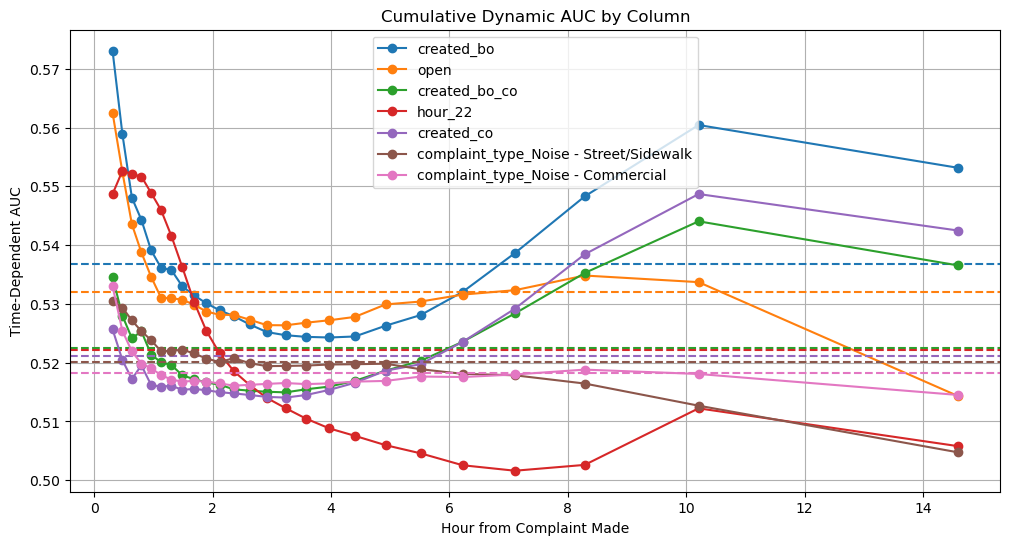

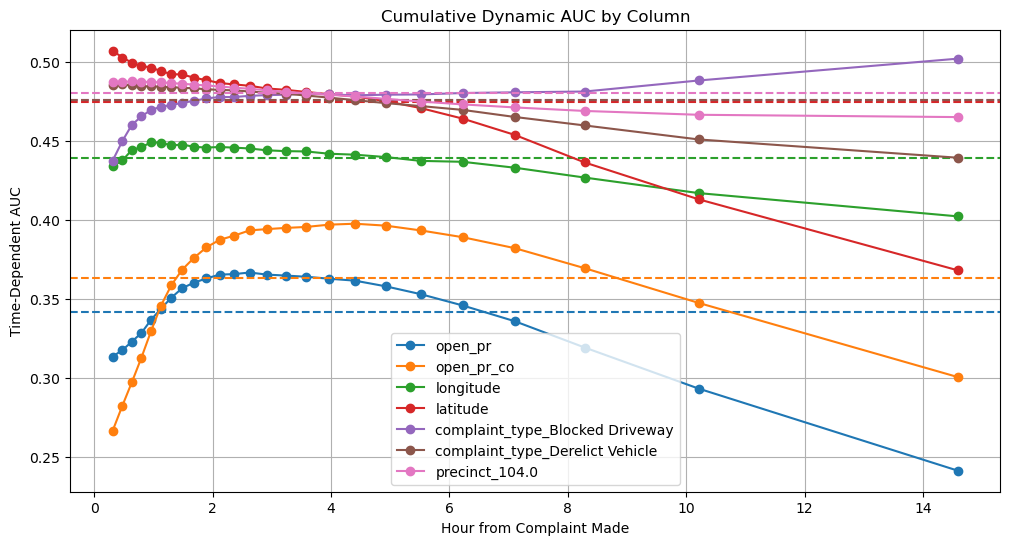

In [10]:


get_variable_impact_auc(
    X_test,
    y_train,
    y_test,
    times,
    assets_path,
    "Random Survival Forest",
    num_cols = 7,
    do_concord = False,
    do_top = True,
    do_bottom = True
)

In [11]:
result = permutation_importance(rsf, X_test[:chunk_size], y_test[:chunk_size], n_repeats=5, random_state=hyper.seed, max_samples=0.10)

imp_df = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)


In [12]:
imp_df.loc[(imp_df['importances_mean'] != 0)].sort_values("importances_mean")

,importances_mean,importances_std
created_bo,-0.020617,0.008846
precinct_77.0,-0.010555,0.005971
precinct_110.0,-0.008996,0.006575
precinct_43.0,-0.007850,0.002048
precinct_79.0,-0.006017,0.005201
...,...,...
open_pr_co,0.012663,0.007444
precinct_34.0,0.013695,0.009445
precinct_44.0,0.017935,0.008165
precinct_47.0,0.019929,0.010519


In [13]:
imp_df["low95"] = imp_df["importances_mean"] - imp_df["importances_mean"]*1.96
imp_df["high"] = imp_df["importances_mean"] + imp_df["importances_mean"]*1.96
imp_df[(imp_df["low95"] <= 0) & (imp_df["high"] >=0)]

,importances_mean,importances_std,low95,high
complaint_type_Derelict Vehicle,0.027172,0.015239,-0.026085,0.080428
precinct_47.0,0.019929,0.010519,-0.019132,0.058989
precinct_44.0,0.017935,0.008165,-0.017217,0.053087
precinct_34.0,0.013695,0.009445,-0.013147,0.040536
open_pr_co,0.012663,0.007444,-0.012157,0.037483
precinct_46.0,0.012021,0.010304,-0.011541,0.035583
precinct_104.0,0.011334,0.010580,-0.010880,0.033548
precinct_63.0,0.008744,0.002327,-0.008394,0.025882
hour_22,0.007139,0.002753,-0.006854,0.021133
precinct_62.0,0.005971,0.006934,-0.005732,0.017673


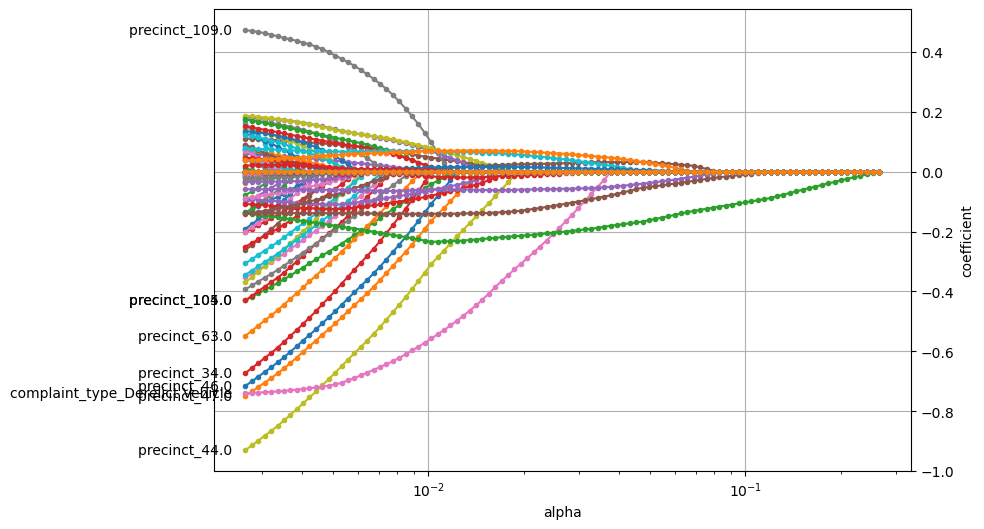

In [14]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(X_train, y_train)
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=X_train.columns, columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=9)

In [18]:
estimated_alphas = cox_elastic_net.alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=hyper.seed)
gcv = GridSearchCV(
    CoxnetSurvivalAnalysis(l1_ratio=0.9),
    param_grid={"alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(X_train, y_train)

cv_results = pd.DataFrame(gcv.cv_results_)


/home/jackmorris/miniconda3/envs/capstone/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)


In [ ]:
alphas = cv_results.alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)


In [ ]:
best_model = gcv.best_estimator_ #.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

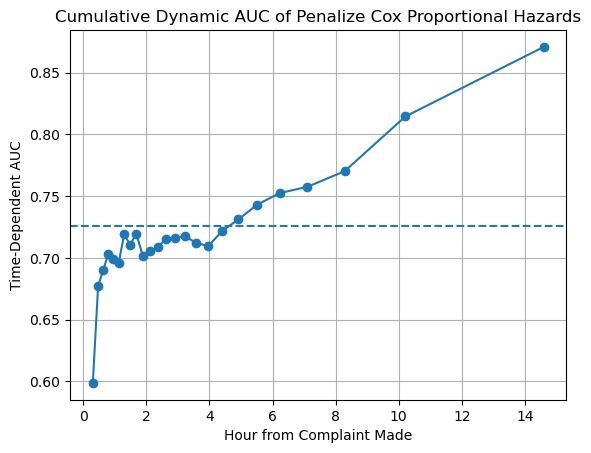

In [12]:
cph_risk_scores = cox_elastic_net.predict(X_test[:chunk_size])
cph_auc, cph_mean_auc = plot_cda(y_train, y_test, cph_risk_scores, times, "Penalize Cox Proportional Hazards", chunk_size)

In [ ]:

concordance = cox_elastic_net.score(X_test, y_test)
print(concordance)

In [24]:
best_model = cox_elastic_net.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=X_train.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

AttributeError: 'CoxnetSurvivalAnalysis' object has no attribute 'best_estimator_'

In [ ]:

cv = KFold(n_splits=3, shuffle=True, random_state=hyper.seed)
cv_param_grid = {
    "estimator__max_depth": np.arange(1, 10, dtype=int),
}
rsf = GridSearchCV(
    as_concordance_index_ipcw_scorer(rsf_gbsg, tau=gbsg_times[-1]),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(X_train, y_train)